### Imports

In [1]:
from datasets import load_dataset
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import utils
import training

/home/gberthelier/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/gberthelier/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:64: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


No Bottleneck unit testing available.


In [2]:
seed = 42
node = "taurus-11"
site = "lyon"

### Datasets

In [3]:
#datasets

t1 = perf_counter()
dataset_en = load_dataset("amazon_reviews_multi","en")["train"].remove_columns(["review_id","product_id","reviewer_id","review_title","language"]).shuffle(seed).select(range(2000))
dataset_fr = load_dataset("amazon_reviews_multi","fr")["train"].remove_columns(["review_id","product_id","reviewer_id","review_title","language"]).shuffle(seed).select(range(2000))
dataset_en = dataset_en.rename_column("review_body","text")
dataset_fr = dataset_fr.rename_column("review_body","text")

dataset_en = dataset_en.select(np.where(np.array(dataset_en["product_category"]) != 'digital_video_download')[0])

stars_label = False
if stars_label:
    dataset_en = dataset_en.map(lambda data: {"label": data["stars"]-1})
    dataset_fr = dataset_fr.map(lambda data: {"label": data["stars"]-1})
    label_dicts = [{k:f"LABEL_{k}" for k in range(5)},{f"LABEL_{k}":k for k in range(5)}]
else:
    products = np.unique(dataset_en["product_category"])
    label_dicts = [{k:key for k,key in enumerate(products)},{key:k for k,key in enumerate(products)}]
    dataset_en = dataset_en.map(lambda data: {"label": label_dicts[1][data["product_category"]]})
    dataset_fr = dataset_fr.map(lambda data: {"label": label_dicts[1][data["product_category"]]})
    
    
def remove_outliers(dataset,fraction,key):
    """keep fraction of dataset for key"""
    A = np.array(dataset[key])
    m, M = min(A), max(A)
    length = M-m
    outl = (1-fraction)*length
    idx = np.where((A<M-outl) & (A>m+outl))[0]
    return dataset.select(idx)

dataset_en = dataset_en.map(lambda data: {"words":len(data["text"].split(" ")),"uniques":len(np.unique(data["text"].split(" "))),"length":len(data["text"])})
dataset_fr = dataset_fr.map(lambda data: {"words":len(data["text"].split(" ")),"uniques":len(np.unique(data["text"].split(" "))),"length":len(data["text"])})
dataset_en = remove_outliers(dataset_en,0.99,"words")
dataset_fr = remove_outliers(dataset_fr,0.99,"words")

t2 = perf_counter()
print(f"Done in {(t2-t1)/60:.2f} min")
print("English size : ", dataset_en.num_rows)
print("French size : ", dataset_fr.num_rows)


Found cached dataset amazon_reviews_multi (/home/gberthelier/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/gberthelier/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-7af6fbab5d472af1.arrow
Found cached dataset amazon_reviews_multi (/home/gberthelier/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/gberthelier/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-7cfa686f3afac7c0.arrow
Loading cached processed dataset at /home/gberthelier/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-74fdf8a1ec42b19e.arrow
Loading cached processed dataset at /home/gberthelier/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-8dfa64f6f9df19c4.arrow
Loading cached processed dataset at /home/gberthelier/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-3e8606a73d7207de.arrow
Loading cached processed dataset at /home/gberthelier/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf

Done in 0.05 min
English size :  1826
French size :  1940


In [15]:
label_dicts

[{0: 'apparel',
  1: 'automotive',
  2: 'baby_product',
  3: 'beauty',
  4: 'book',
  5: 'camera',
  6: 'digital_ebook_purchase',
  7: 'drugstore',
  8: 'electronics',
  9: 'furniture',
  10: 'grocery',
  11: 'home',
  12: 'home_improvement',
  13: 'industrial_supplies',
  14: 'jewelry',
  15: 'kitchen',
  16: 'lawn_and_garden',
  17: 'luggage',
  18: 'musical_instruments',
  19: 'office_product',
  20: 'other',
  21: 'pc',
  22: 'personal_care_appliances',
  23: 'pet_products',
  24: 'shoes',
  25: 'sports',
  26: 'toy',
  27: 'video_games',
  28: 'watch',
  29: 'wireless'},
 {'apparel': 0,
  'automotive': 1,
  'baby_product': 2,
  'beauty': 3,
  'book': 4,
  'camera': 5,
  'digital_ebook_purchase': 6,
  'drugstore': 7,
  'electronics': 8,
  'furniture': 9,
  'grocery': 10,
  'home': 11,
  'home_improvement': 12,
  'industrial_supplies': 13,
  'jewelry': 14,
  'kitchen': 15,
  'lawn_and_garden': 16,
  'luggage': 17,
  'musical_instruments': 18,
  'office_product': 19,
  'other': 20,
 

Mean words (English dataset) :  37.5
Median words (English dataset) :  27
Mean uniques (English dataset) :  30.9
Median uniques (English dataset) :  24
Mean length (English dataset) :  196.2
Median length (English dataset) :  141


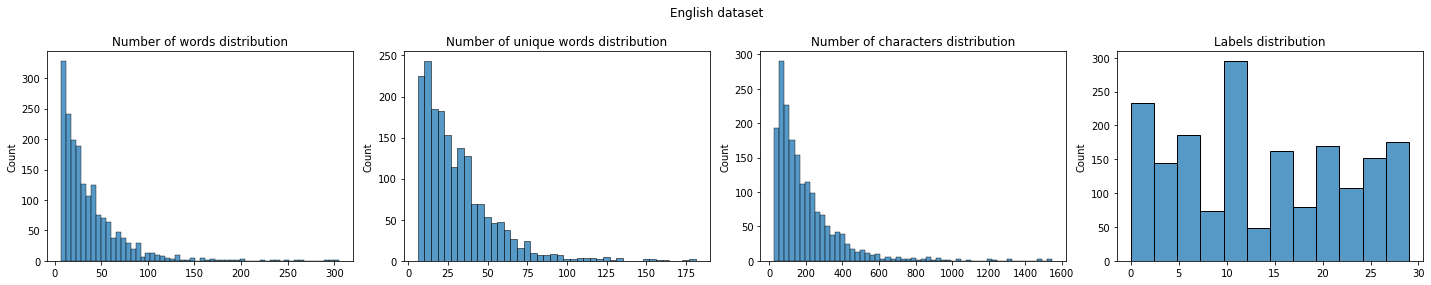

-------------

Mean words (French dataset) :  28.2
Median words (French dataset) :  22
Mean uniques (French dataset) :  25.0
Median uniques (French dataset) :  21
Mean length (French dataset) :  159.1
Median length (French dataset) :  128


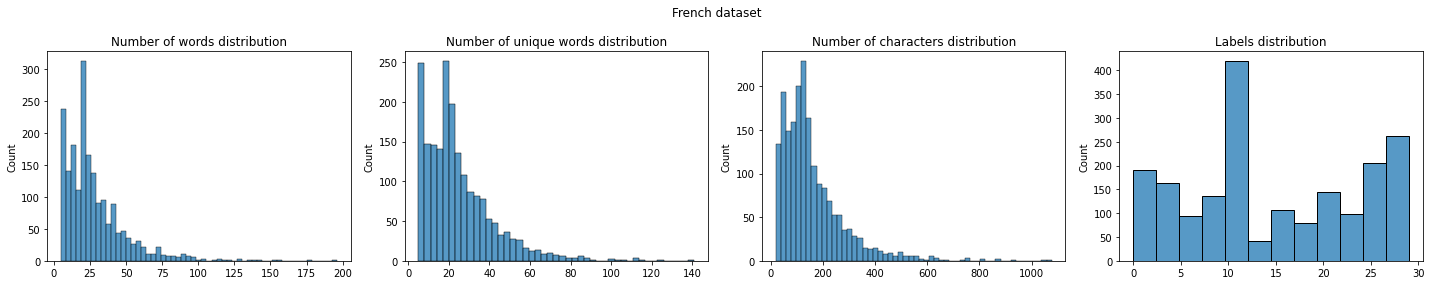

In [11]:
def med(L):
    A = np.array(L)
    A = np.sort(A)
    n = len(A)
    return A[int(n/2)]

def plot_dataset(dataset,title,do_means=True,fixed_words=False):
    
    if do_means:
        for key in ["words","uniques","length"]:
            print(f"Mean {key} ({title}) : ",round(np.mean(dataset[key]),1))
            print(f"Median {key} ({title}) : ",med(dataset[key]))
    
    if not fixed_words:
        fig, axes = plt.subplots(1, 4,figsize=(20, 4))
        sns.histplot(ax = axes[0],x=dataset["words"]).set(title="Number of words distribution")
        sns.histplot(ax = axes[1],x=dataset["uniques"]).set(title="Number of unique words distribution")
        sns.histplot(ax = axes[2],x=dataset["length"]).set(title="Number of characters distribution")
        sns.histplot(ax = axes[3],x=dataset["label"]).set(title="Labels distribution")
        plt.suptitle(title)
        fig.tight_layout()
        plt.show()
    else:
        fig, axes = plt.subplots(1, 2,figsize=(10, 4))
        sns.histplot(ax = axes[0],x=dataset["uniques"]).set(title="Number of unique words distribution")
        sns.histplot(ax = axes[1],x=dataset["length"]).set(title="Number of characters distribution")
        plt.suptitle(title)
        fig.tight_layout()
        plt.show()

plot_dataset(dataset_en,"English dataset")
print("-------------")
print("")
plot_dataset(dataset_fr,"French dataset")

  0%|          | 0/2 [00:00<?, ?ba/s]

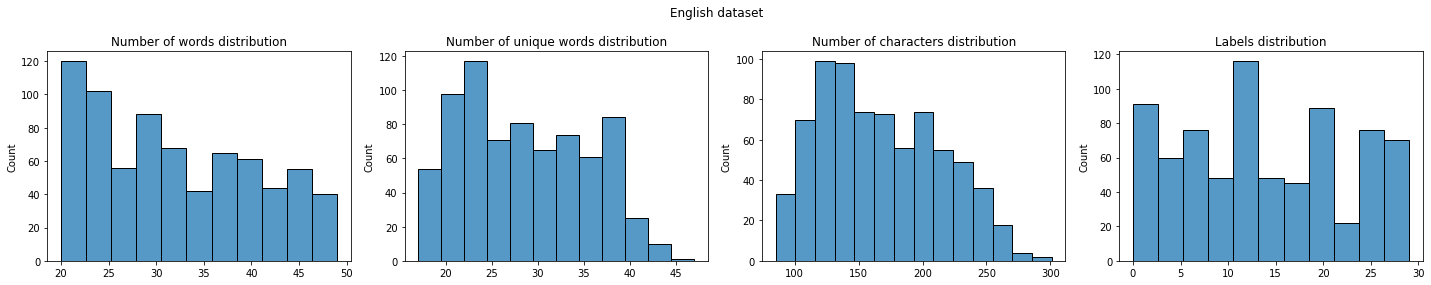

-------------



  0%|          | 0/2 [00:00<?, ?ba/s]

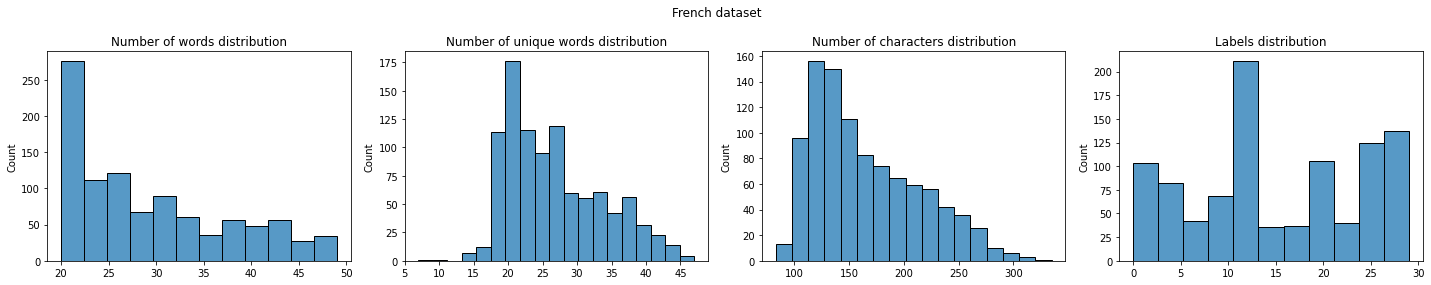

In [17]:
def filter_fixed(dataset,key,const):
    return dataset.filter(lambda data: data[key] in const)
    
plot_dataset(filter_fixed(dataset_en,"words",range(20,50)),"English dataset",do_means=False)#,fixed_words=True)
print("-------------")
print("")
plot_dataset(filter_fixed(dataset_fr,"words",range(20,50)),"French dataset",do_means=False)#,fixed_words=True)

### Training

In [6]:
tokenizer_en = utils.get_tokenizer("roberta-base")
tokenizer_fr = utils.get_tokenizer("camembert-base")
dataset_en = utils.tokenize_dataset(dataset_en,tokenizer_en)
dataset_fr = utils.tokenize_dataset(dataset_fr,tokenizer_fr)

Loading cached processed dataset at /home/gberthelier/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-62289b91b854a6d3.arrow
Loading cached processed dataset at /home/gberthelier/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-599c02ff4b9d520a.arrow



English
Loaded epoch size : 1
Loaded epoch size : 3
Loaded epoch size : 5
Loaded epoch size : 7
Loaded epoch size : 11

French
Loaded epoch size : 1
Loaded epoch size : 3
Loaded epoch size : 5
Loaded epoch size : 7
Loaded epoch size : 11
--------------------
Done in 0.01 min
 


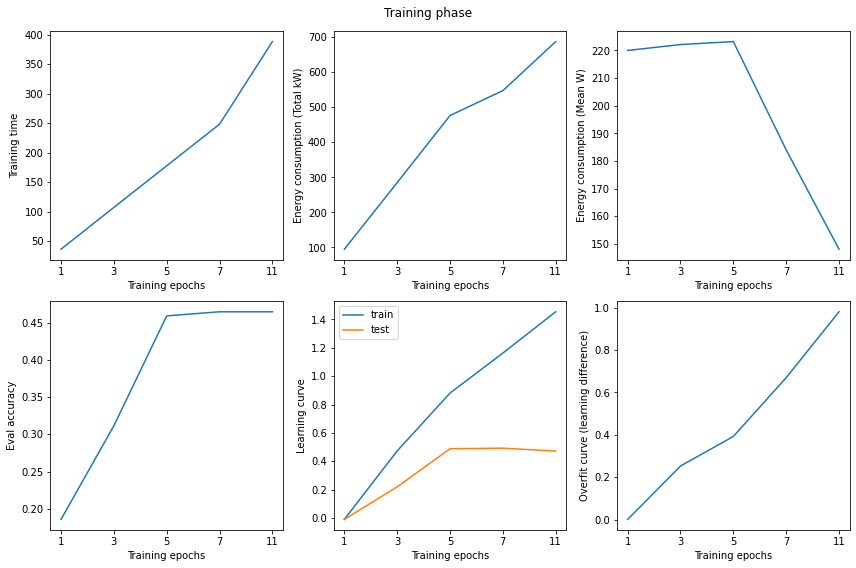

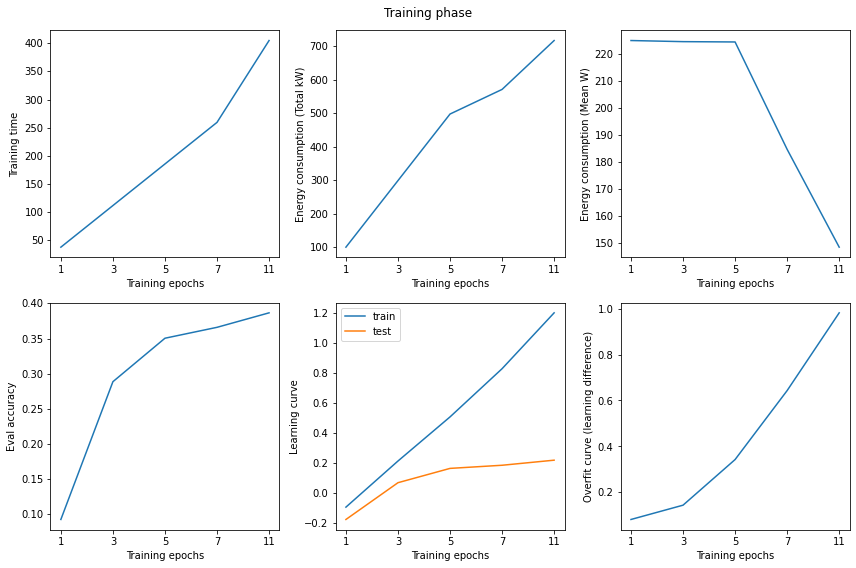

In [8]:
utils.reload(utils)
utils.reload(training)
epoch_bench = [1,3,5,7,11]#,13] fait sur en, pas sur fr
T1 = perf_counter()

train_en = True
print("")
print("English") 
train_test = dataset_en.train_test_split(test_size=0.1,seed=seed)
training.train_grid(train_test["train"],train_test["test"],tokenizer_en,epoch_bench,label_dicts,target_dir="target_model_en",seed=seed,compute=train_en,print_graphs=True,model_name="roberta-base",node=node,site=site,start_at=5,is_hcl=False)

train_fr = True
print("")
print("French") 
train_test = dataset_fr.train_test_split(test_size=0.1,seed=seed)
training.train_grid(train_test["train"],train_test["test"],tokenizer_fr,epoch_bench,label_dicts,target_dir="target_model_fr",seed=seed,compute=train_fr,print_graphs=True,model_name="camembert-base",node=node,site=site,start_at=5,is_hcl=False)
    
utils.get_delay(T1)